数据前3行:
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  

--- 1.1 数据信息查看 ---
数据形状: (2900, 8)

数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   So

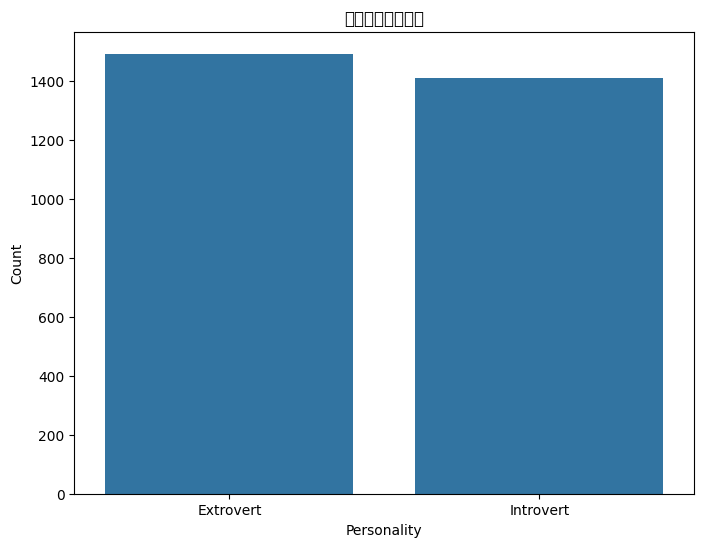


--- 2.3 不同性格类型的数值特征分布 ---


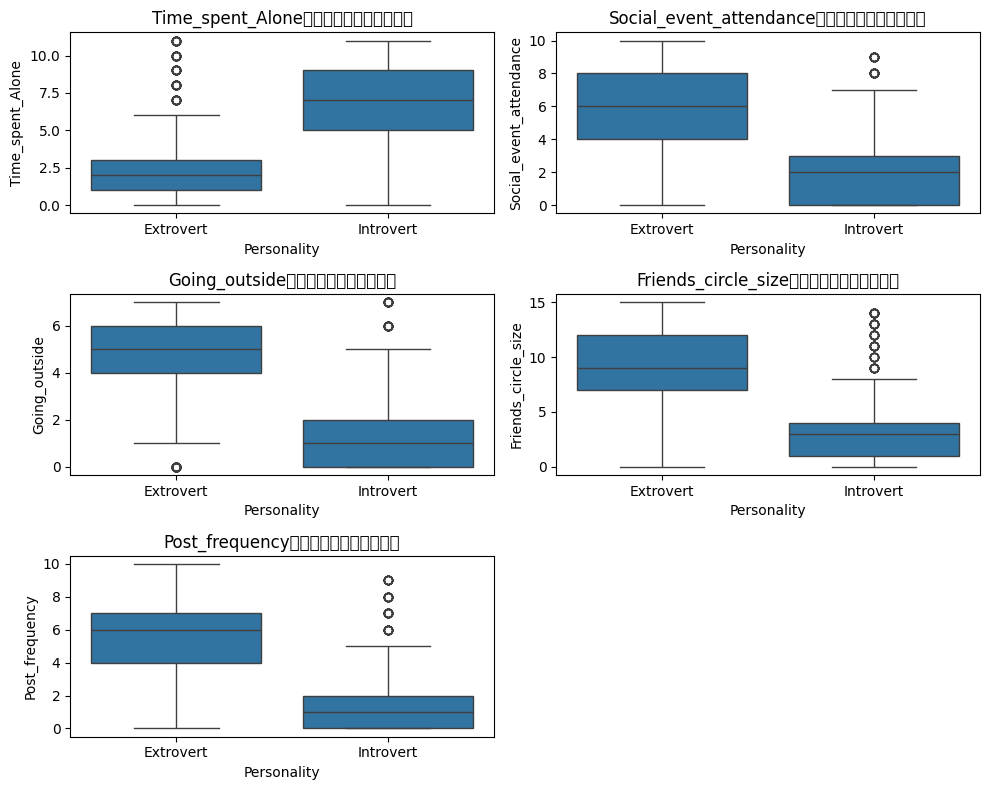


--- 2.4 特征变量关系矩阵图 ---


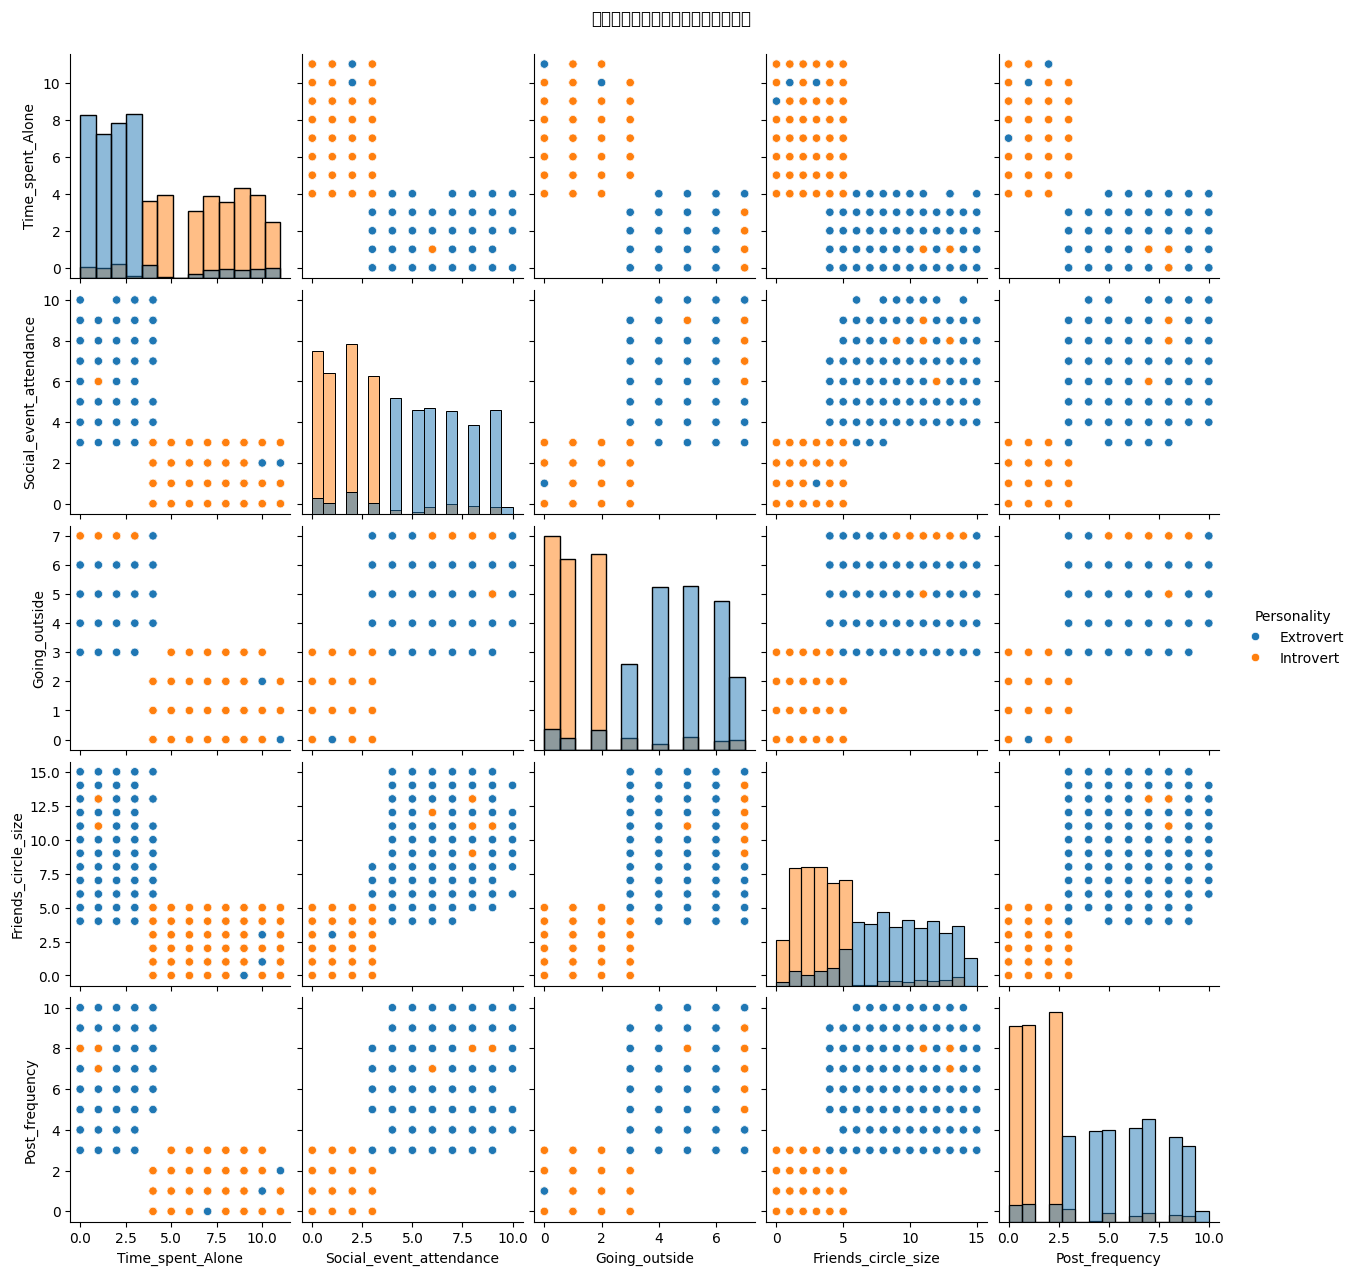


--- 2.5 特征相关性热力图 ---


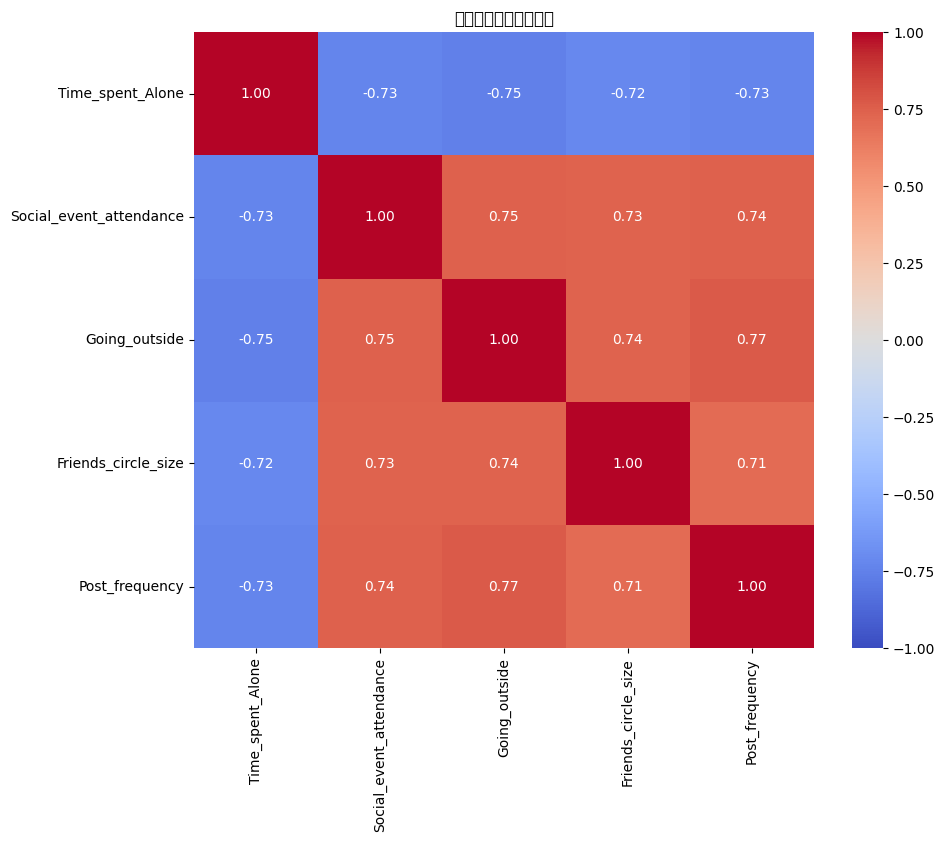


--- 3.1 目标特征编码 ---
编码映射关系: {'Extrovert': np.int64(0), 'Introvert': np.int64(1)}

--- 3.2 缺失值处理 ---

--- 3.3 分类特征编码 ---
编码后的特征列数量: 7

--- 3.4 异常值处理 ---
数值型特征的异常值已进行封顶处理。

--- 4.1 划分数据集 ---

--- 4.2 特征字段特征工程 ---
训练集特征数量（含衍生特征和交互项）: 15

--- 4.3 模型选择 ---

--- 4.4 超参数调优 ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# 设置随机种子
np.random.seed(42)

# --- 1. 数据加载与查看 ---
# 注意：请确保文件路径 '/home/mw/input/ww11233323/personality_dataset.csv' 正确
data = pd.read_csv('C:/Users/Administrator/Desktop/EandI/personality_dataset.csv')
print("数据前3行:")
print(data.head(3))

# 数据信息查看
print("\n--- 1.1 数据信息查看 ---")
print("数据形状:", data.shape)
print("\n数据信息:")
print(data.info())
print("\n缺失值统计:")
print(data.isnull().sum())

# --- 2. 数据可视化分析 ---
print("\n--- 2.1 字段变量类型定义 ---")
# 字段变量类型定义
numeric_columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
'Friends_circle_size', 'Post_frequency']
categorical_columns = ['Stage_fear', 'Drained_after_socializing']
target_column = 'Personality' # 目标变量

print("\n--- 2.2 性格类型分布情况 ---")
# 性格类型分布情况 
plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=data)
plt.title('性格类型分布情况')
plt.xlabel('Personality')
plt.ylabel('Count')
plt.show()

print("\n--- 2.3 不同性格类型的数值特征分布 ---")
# 不同性格类型的数值特征分布 
plt.figure(figsize=(10, 8))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=target_column, y=col, data=data)
    plt.title(f'{col}在不同性格类型中的分布')
plt.tight_layout()
plt.show()

print("\n--- 2.4 特征变量关系矩阵图 ---")
# 特征变量关系矩阵图 
sns.pairplot(data[numeric_columns + [target_column]],
hue=target_column,
diag_kind='hist')
plt.suptitle('不同性格类型的数值特征关系矩阵图', y=1.02)
plt.show()

print("\n--- 2.5 特征相关性热力图 ---")
# 特征相关性热力图 
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_columns].corr(),
annot=True,
cmap='coolwarm',
fmt='.2f',
vmin=-1, vmax=1)
plt.title('数值特征相关性热力图')
plt.show()

# --- 3. 特征工程 ---
print("\n--- 3.1 目标特征编码 ---")
# 对目标变量进行编码
le = LabelEncoder()
data[target_column] = le.fit_transform(data[target_column])
print(f"编码映射关系: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\n--- 3.2 缺失值处理 ---")
# 处理缺失值
# 数值型特征：使用中位数填充缺失值
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])
# 分类特征：使用众数（出现频次最高的值）填充缺失值
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

print("\n--- 3.3 分类特征编码 ---")
# 分类特征编码
# 为分类特征创建二进制虚拟变量
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# 更新特征列列表
encoded_columns = [col for col in data.columns if col != target_column]
print(f"编码后的特征列数量: {len(encoded_columns)}")

print("\n--- 3.4 异常值处理 ---")
# 对异常值进行封顶处理（而非删除）
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
print("数值型特征的异常值已进行封顶处理。")

# --- 4. 模型预测 ---
print("\n--- 4.1 划分数据集 ---")
# 划分数据集
X = data.drop(columns=[target_column])
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("\n--- 4.2 特征字段特征工程 ---")
# 确保训练集和测试集保持DataFrame格式
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# 衍生特征：独处时间与社交参与比率
X_train['Alone_to_Social_Ratio'] = X_train['Time_spent_Alone'] / (X_train['Social_event_attendance'] + 1)
X_test['Alone_to_Social_Ratio'] = X_test['Time_spent_Alone'] / (X_test['Social_event_attendance'] + 1)

# 衍生特征：社交舒适度指数
X_train['Social_Comfort_Index'] = (X_train['Friends_circle_size'] +
X_train['Post_frequency'] -
X_train['Stage_fear_Yes']) / 3
X_test['Social_Comfort_Index'] = (X_test['Friends_circle_size'] +
X_test['Post_frequency'] -
X_test['Stage_fear_Yes']) / 3

# 衍生特征：社交过载指数
X_train['Social_Overload'] = X_train['Drained_after_socializing_Yes'] * X_train['Social_event_attendance']
X_test['Social_Overload'] = X_test['Drained_after_socializing_Yes'] * X_test['Social_event_attendance']

# 创建分桶特征：独处时间
X_train['Time_spent_Alone_Binned'] = pd.qcut(X_train['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'])
X_test['Time_spent_Alone_Binned'] = pd.qcut(X_test['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'])
X_train = pd.get_dummies(X_train, columns=['Time_spent_Alone_Binned'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Time_spent_Alone_Binned'], drop_first=True)

# 创建多项式特征
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_features_train = poly.fit_transform(X_train[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_features_test = poly.transform(X_test[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_feature_names = poly.get_feature_names_out(['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size'])
X_train[poly_feature_names] = poly_features_train
X_test[poly_feature_names] = poly_features_test

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"训练集特征数量（含衍生特征和交互项）: {X_train.shape[1]}")

print("\n--- 4.3 模型选择 ---")
models = {
    'logistic': {
        'model': LogisticRegression(max_iter=1000),
        'use_scaled': True,
        'params': {'C': np.logspace(-4, 4, 20), 'solver': ['lbfgs', 'liblinear']}
    },
    'svm': {
        'model': SVC(probability=True),
        'use_scaled': True,
        'params': {'C': np.logspace(-3, 3, 20), 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1, 1]}
    },
    'rf': {
        'model': RandomForestClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
    },
    'gb': {
        'model': GradientBoostingClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'use_scaled': True,
        'params': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=42),
        'use_scaled': False,
        'params': {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
    },
    'xgb': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'subsample': [0.8]}
    }
}

print("\n--- 4.4 超参数调优 ---")
# 超参数调优过程
results = []
for model_name, mp in models.items():
    clf = RandomizedSearchCV(mp['model'],
                             mp['params'],
                             n_iter=20,
                             cv=3,
                             scoring='f1_weighted',
                             n_jobs=-1,
                             random_state=42)

    X_train_current = X_train_scaled if mp['use_scaled'] else X_train
    clf.fit(X_train_current, y_train)

    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

print("\n--- 4.5 超参数调优后的模型结果 ---")
# 将结果转换为DataFrame便于分析
df_results = pd.DataFrame(results)
# 按分数排序找出最优模型
df_results.sort_values('best_score', ascending=False, inplace=True)
# 打印所有模型的调优结果
print(df_results[['model', 'best_score']])
# 输出最优模型参数
best_model_name = df_results.iloc[0]['model']
best_params = df_results.iloc[0]['best_params']
print(f"\n最优模型: {best_model_name}")
print(f"最优参数: {best_params}")

print("\n--- 4.6 Stacking集成模型训练 ---")
# 创建基础模型估计器列表
estimators = [
    # 1. 随机森林模型
    ('rf', RandomForestClassifier(
        **df_results.loc[df_results['model'] == 'rf']['best_params'].iloc[0],
        random_state=42
    )),

    # 2. 梯度提升树模型
    ('gb', GradientBoostingClassifier(
        **df_results.loc[df_results['model'] == 'gb']['best_params'].iloc[0],
        random_state=42
    )),

    # 3. XGBoost模型
    ('xgb', XGBClassifier(
        **df_results.loc[df_results['model'] == 'xgb']['best_params'].iloc[0],
        random_state=42,
        eval_metric='logloss'
    )),

    # 4. 支持向量机模型
    ('svm', SVC(
        **df_results.loc[df_results['model'] == 'svm']['best_params'].iloc[0],
        probability=True
    ))
]
# 构建堆叠分类模型
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)
# 在标准化后的训练数据上训练堆叠模型
stacking_model.fit(X_train_scaled, y_train)
# 对堆叠模型进行交叉验证评估
stacking_scores = cross_val_score(
    stacking_model,
    X_train_scaled,
    y_train,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)
# 打印交叉验证结果：平均值±标准差
print(f"\n堆叠模型交叉验证加权F1分数: {stacking_scores.mean():.3f} ± {stacking_scores.std():.3f}")

print("\n--- 4.7 Stacking模型结果可视化分析 ---")
# 在测试集上评估堆叠模型的最终性能
y_pred = stacking_model.predict(X_test_scaled)
# 打印详细的分类评估报告
print("\n堆叠模型分类评估报告:")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))

# 绘制混淆矩阵可视化图表 
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='d',
            cmap='Blues')
plt.title('Stacking模型混淆矩阵')
plt.xlabel('预测类别')
plt.ylabel('真实类别')
plt.show()

# 绘制ROC曲线 
fpr, tpr, _ = roc_curve(y_test, stacking_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = roc_auc_score(y_test, stacking_model.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC曲线 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('假正率(FPR)')
plt.ylabel('真正率(TPR)')
plt.title('ROC曲线分析')
plt.legend()
plt.show()

print("\n--- 4.8 随机森林特征重要性分析 ---")
# 随机森林特征重要性分析
rf_model = RandomForestClassifier(
    **df_results.loc[df_results['model'] == 'rf']['best_params'].iloc[0],
    random_state=42
)
rf_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    '特征': X_train.columns,
    '重要性': rf_model.feature_importances_
}).sort_values(by='重要性', ascending=False)
print("\n特征重要性排序（随机森林）：")
print(feature_importance)
# 创建特征重要性条形图 
plt.figure(figsize=(10, 6))
sns.barplot(x='重要性', y='特征', data=feature_importance.head(15)) # 只显示前15个特征
plt.title('随机森林特征重要性分析')
plt.show()